In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update('jax_default_device',jax.devices()[1])
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp
import time
import matplotlib.pyplot as plt
from pysindy import EnsembleOptimizer
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})

In [2]:
exp_data = LorenzExp
initial_state = jnp.array([ -8,8,27.])
dt = 0.025
t_train = jnp.arange(0,10.01,dt)
noise_var = 0.1
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 505
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=29,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

lorenz_sol = expdata.system_sol
t_train = expdata.t_train

In [3]:
true_sigma2 = 0.05
x_vals = jax.vmap(lorenz_sol.evaluate)(t_train)
x_train = x_vals + (
    jnp.sqrt(true_sigma2) * 
    jax.random.normal(jax.random.PRNGKey(32),(len(t_train),3))
)


num_obs_chain = 10
measurement_vecs = jnp.tile(
    jnp.repeat(jnp.eye(3),num_obs_chain,axis=0),(int(len(t_train)/(num_obs_chain * 3)+1),1))[:len(t_train)]

y_obs = jnp.sum(measurement_vecs*x_train,axis=1)

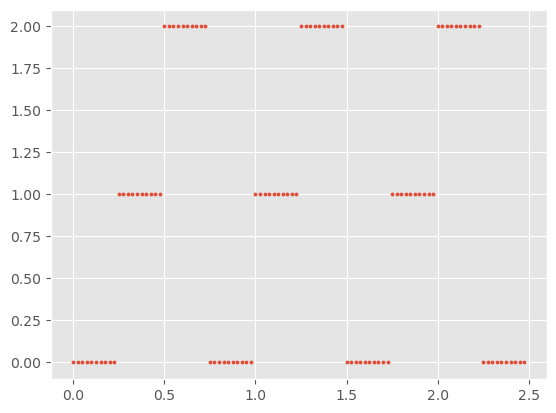

In [4]:
plt.scatter(t_train[:100],jnp.argmax(measurement_vecs,axis=1)[:100],s = 5)

In [5]:
n_colloc = 500
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.25,alpha = 0.01)
    )

In [6]:
optimizer = AnnealedAlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y','z']
)

model.fit(
    t_train,
    t_colloc = None,
    w_colloc = None,
    partialobs_v = measurement_vecs,
    partialobs_y = y_obs,
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params

model.print()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.05181254, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Solving for data_weight = 1.0, colloc_weight = 800.0 beta_reg = 0.008


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 1.111e+07, gradnorm = 6.7e+06, alpha = 7.5, improvement_ratio = 0.2079
Iteration 1, loss = 9.784e+06, gradnorm = 6.538e+07, alpha = 68.34, improvement_ratio = 0.1198
Iteration 2, loss = 9.008e+06, gradnorm = 8.005e+07, alpha = 123.0, improvement_ratio = 0.07935
Iteration 3, loss = 6.253e+06, gradnorm = 1.08e+08, alpha = 100.0, improvement_ratio = 0.306
Iteration 4, loss = 4.912e+06, gradnorm = 7.719e+07, alpha = 150.0, improvement_ratio = 0.2148
Iteration 5, loss = 6.883e+05, gradnorm = 6.782e+07, alpha = 83.33, improvement_ratio = 0.8607
Iteration 100, loss = 157.5, gradnorm = 6.404e+04, alpha = 6.491, improvement_ratio = 0.4818
Iteration 200, loss = 70.33, gradnorm = 4.797e+04, alpha = 4.507, improvement_ratio = 0.5656
Iteration 300, loss = 12.87, gradnorm = 1.018e+04, alpha = 0.6066, improvement_ratio = 0.8153
Line Search Failed!
Final Iteration Results
Iteration 375, loss = 9.543, gradnorm = 0.0001167, alpha = 2.562e+04, improvement_ratio = -inf
Solving for data

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.546, gradnorm = 116.3, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.546, gradnorm = 50.74, alpha = 3.472, improvement_ratio = 0.9999
Iteration 2, loss = 9.546, gradnorm = 2.095, alpha = 2.894, improvement_ratio = 0.9999
Iteration 3, loss = 9.546, gradnorm = 0.4321, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 9.546, gradnorm = 0.4308, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 9.546, gradnorm = 0.4015, alpha = 1.674, improvement_ratio = 1.0
Line Search Failed!
Final Iteration Results
Iteration 54, loss = 9.546, gradnorm = 0.002065, alpha = 5.274e+03, improvement_ratio = -3.937e+03
Solving for data_weight = 1.0, colloc_weight = 20000.0 beta_reg = 0.002


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.546, gradnorm = 116.4, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.546, gradnorm = 18.34, alpha = 3.472, improvement_ratio = 0.9999
Iteration 2, loss = 9.546, gradnorm = 0.4079, alpha = 2.894, improvement_ratio = 0.9999
Iteration 3, loss = 9.546, gradnorm = 0.1319, alpha = 2.411, improvement_ratio = 1.0
Iteration 4, loss = 9.546, gradnorm = 0.1227, alpha = 2.009, improvement_ratio = 1.0
Iteration 5, loss = 9.546, gradnorm = 0.09935, alpha = 1.674, improvement_ratio = 1.0
Line Search Failed!
Final Iteration Results
Iteration 58, loss = 9.546, gradnorm = 0.003961, alpha = 3.99e+05, improvement_ratio = -inf
Solving for data_weight = 1.0, colloc_weight = 100000.0 beta_reg = 0.001


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 9.546, gradnorm = 116.4, alpha = 4.167, improvement_ratio = 1.0
Iteration 1, loss = 9.546, gradnorm = 4.941, alpha = 3.472, improvement_ratio = 0.9998
Iteration 2, loss = 9.546, gradnorm = 0.05583, alpha = 2.894, improvement_ratio = 1.0
Iteration 3, loss = 9.546, gradnorm = 0.04225, alpha = 2.411, improvement_ratio = 1.001
Iteration 4, loss = 9.546, gradnorm = 0.03045, alpha = 2.009, improvement_ratio = 1.004
Iteration 5, loss = 9.546, gradnorm = 0.03728, alpha = 1.674, improvement_ratio = 1.009
Line Search Failed!
Final Iteration Results
Iteration 40, loss = 9.546, gradnorm = 0.01268, alpha = 624.5, improvement_ratio = -630.2
Model after smooth warm start
(x)' = 0.209 1 + -8.858 x + 9.128 y + 0.204 z + 0.082 x^2 + -0.093 x y + -0.034 x z + 0.020 y^2 + 0.024 y z + -0.008 z^2
(y)' = -3.622 1 + 27.178 x + -0.344 y + 0.378 z + 0.006 x^2 + -0.008 x y + -0.980 x z + 0.003 y^2 + -0.015 y z + -0.009 z^2
(z)' = -3.046 1 + 0.538 x + -0.388 y + -2.208 z + 0.071 x^2 + 0.935 x 

In [7]:
expdata.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y


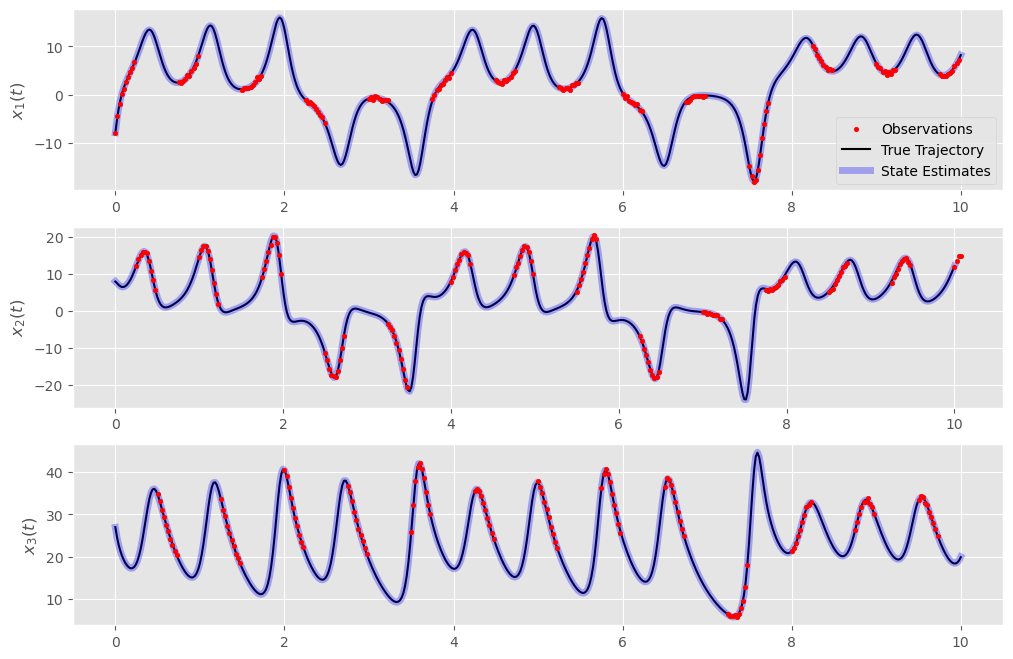

In [8]:
t_grid = jnp.linspace(0,10,500)
state_preds = model.predict_state(t_grid)
true_states = jax.vmap(expdata.system_sol.evaluate)(t_grid)
plt.figure(figsize=(12,8))
for dim in range(3):
	plt.subplot(3,1,dim+1)
	obs_index = jnp.where(jnp.argmax(measurement_vecs,axis=1) == dim)
	plt.scatter(t_train[obs_index],y_obs[obs_index],label = 'Observations',s = 10,zorder = 10,c='red')
	plt.plot(t_grid,true_states[:,dim],label = 'True Trajectory',c='black')
	plt.plot(t_grid,state_preds[:,dim],label = 'State Estimates',c ='blue',alpha = 0.3,lw = 5)
	if dim ==0:
		plt.legend()
	plt.ylabel(f"$x_{dim+1}(t)$")
plt.savefig("figures/stream10.pdf")
plt.savefig("figures/stream10.png")

In [9]:
import diffrax
def model_ode(t,x,args = None):
    return model.predict(x)

dt0 = 0.005
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol =1e-8)
save_at = diffrax.SaveAt(dense=True)  # Save at regular intervals
pred_extend = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(model_ode),
	solver = diffrax.Tsit5(),
	t0=t_train[-1],
	t1=20.,
	dt0=dt0,
	y0=expdata.system_sol.evaluate(t_train[-1]),
	saveat=save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt0)
)

from data.lorenz import lorenz_system

lorenz_args = (10.0, 28.0, 8.0/3.0)

true_extend = diffrax.diffeqsolve(
	terms = diffrax.ODETerm(lorenz_system),
    solver = diffrax.Tsit5(),
    t0=t_train[-1],
	t1=20.,
    dt0 = dt0,
    y0 = expdata.system_sol.evaluate(t_train[-1]),
    saveat = save_at,
    stepsize_controller=stepsize_controller,
	max_steps = int(10*(t1-t0)/dt),
	args = lorenz_args
)

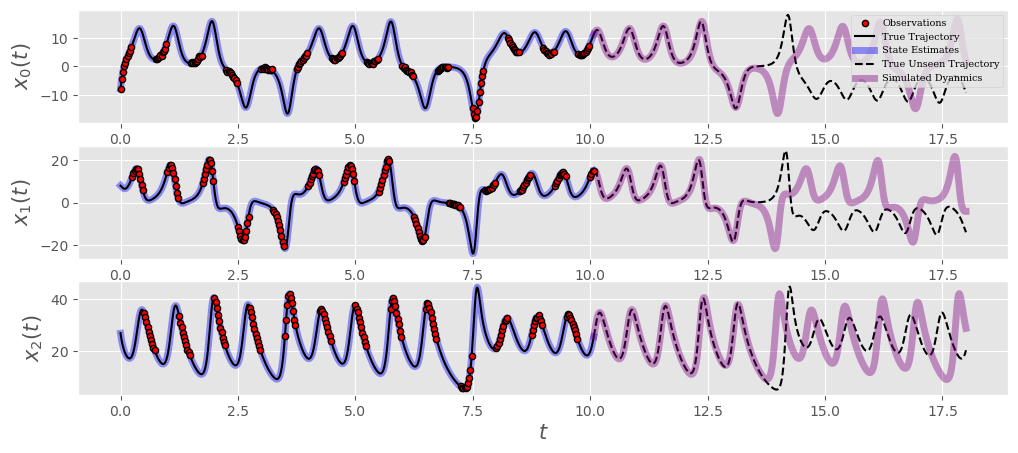

In [10]:
family='serif'
fig, ax = plt.subplots(3,1, figsize=(12,5))
ylabels = [r"$x_0(t)$", r"$x_1(t)$",r"$x_2(t)$"]

t_fine = jnp.linspace(t_train[0],t_train[-1],1000)
x_true = jax.vmap(expdata.system_sol.evaluate)(t_fine)
x_pred = model.predict_state(t_fine)

t_extend = jnp.linspace(t_train[-1],18,500)

x_true_extend = jax.vmap(true_extend.evaluate)(t_extend)
x_sim_extend = jax.vmap(pred_extend.evaluate)(t_extend)

for dim in range(3):
    obs_index = jnp.where(jnp.argmax(measurement_vecs,axis=1) == dim)    
    ax[dim].scatter(
        t_train[obs_index], y_obs[obs_index],facecolors='red',edgecolors='black',lw=1, label='Observations',s=20,zorder=3)
    
    ax[dim].plot(t_fine, x_true[:,dim], label='True Trajectory',c='black',zorder=2)
    ax[dim].plot(t_fine, x_pred[:,dim], label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    # extension 
    ax[dim].plot(t_extend,x_true_extend[:,dim], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[dim].plot(t_extend,x_sim_extend[:,dim],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dyanmics')

    ax[dim].grid(True)
    ax[dim].set_ylabel(ylabels[dim], size=15, family=family)
    if dim==0:
        ax[dim].legend(prop={'family':family,'size':7})
    if dim == 2:
        ax[dim].set_xlabel(r"$t$",size=15, family=family)
# plt.suptitle("Lorenz ", family=family,size=20)
# if savefigs:
plt.savefig(f"figures/lorenz_streams.pdf")
plt.show()
